In [6]:
!pip install PyWavelets


In [7]:
#import Python library
import numpy as np
import pandas as pd
import os
import joblib as jb
from collections import defaultdict
from itertools import groupby
from math import sqrt, atan2
import matplotlib.pyplot as plt
import pywt
from scipy.signal import savgol_filter

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data=[]
labels=[]
file_patterns = [
    "P26_fiber_4.csv", "P27_fiber_4.csv", "P28_fiber_4.csv", "P29_fiber_4.csv", "P30_fiber_4.csv",
    "P26_wood_4.csv", "P27_wood_4.csv", "P28_wood_4.csv", "P29_wood_4.csv", "P30_wood_4.csv",
    "P26_glass_4.csv", "P27_glass_4.csv", "P28_glass_4.csv", "P29_glass_4.csv", "P30_glass_4.csv"
]
dataset_path = "/content/drive/My Drive/wild"

def preprocess_file(file_path):
    result = pd.read_csv(file_path)
    len_= result.shape[0]
    len_=int(abs(0.03*len_))
    # print(len)
    result=result.iloc[len_:-len_, 128:] # remove first 128 rows.

    label= pd.DataFrame(result['headlabel'])
    # label.to_csv(f'{save_path}/{i}_amp/label_{j}', index=False)
    result=result.drop(columns=['timestamp', 'headlabel'], axis=1)

    result.columns=range(len(result.columns))
    # remove null and pilot subcarriers

    delete_idxs =  np.asarray([0,1,2,3,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,254,255])
    result = result.drop(result.columns[delete_idxs], axis=1)
    result.columns=range(len(result.columns))
    data.append(result)
    labels.append(label)

# print(amp_result.shape)
for file_name in file_patterns:
    file_path = os.path.join(dataset_path, file_name)
    if os.path.exists(file_path):
        preprocess_file(file_path)
    else:
        print(f"File not found: {file_path}")



In [9]:
# compute Amplitude and removing nan
# compute amplitude
def amplitude(df):

    df = np.array(df)  # Convert DataFrame to numpy array for efficient computation
    amp = []

    for i in range(len(df)):  # Iterate over each row in the dataset
        imaginary = []
        real = []
        amplitudes = []

        for j in range(len(df[i])):  # Iterate over each element in the row
            if j % 2 == 0:  # Even index corresponds to imaginary part
                imaginary.append(df[i][j])
            else:  # Odd index corresponds to real part
                real.append(df[i][j])

        # Calculate amplitude for each subcarrier
        for k in range(len(imaginary)):
            amplitudes.append(np.sqrt(imaginary[k] ** 2 + real[k] ** 2))

        amp.append(amplitudes)

    # Convert the amplitude list back into a DataFrame
    amp_df = pd.DataFrame(amp)
    amp_df = amp_df.reset_index(drop=True)
    print("Amplitude calculation completed.")
    return amp_df

# remove nan
def remove_nan(matrix_):
    temp = matrix_.copy()
    temp=temp.dropna()
    temp = temp.reset_index(drop=True)
    print("remove_nan completed")
    return  temp

In [10]:
#denoising CSI data
#hampel filter
def hampel_filter(input_matrix, window_size, n_sigmas=3):
    # Perform Hampel filtering
    n_rows, n_cols = input_matrix.shape
    new_matrix = np.zeros_like(input_matrix)
    std_dev = np.std(input_matrix)
    mad = np.median(np.abs(input_matrix - np.median(input_matrix)))

    k = std_dev / (mad)

    for col_idx in range(n_cols):
        for ti in range(n_rows):
            start_idx = max(0, ti - window_size)
            end_idx = min(n_rows, ti + window_size)

            # Calculate the median of the window for the current column
            x0 = np.nanmedian(input_matrix[start_idx:end_idx, col_idx])

            # Calculate the median absolute deviation (MAD) of the window for the current column
            s0 = k * np.nanmedian(np.abs(input_matrix[start_idx:end_idx, col_idx] - x0))

            # Detect outliers based on the median and MAD
            if np.abs(input_matrix[ti, col_idx] - x0) > n_sigmas * s0:
                # Replace outliers with the median value
                new_matrix[ti, col_idx] = x0
            else:
                new_matrix[ti, col_idx] = input_matrix[ti, col_idx]
    print('hampel')
    return new_matrix

# 1-D wavelet transform
def denoise(df,wavelt, sigma):
    dwt = pd.DataFrame()
    # wevelt='bior1.1'
    for i in range(len(df.columns)):
        signal = df.iloc[:, i]
        # Perform wavelet decomposition
        coeff = pywt.wavedec(signal, wavelet=wavelt, mode="per")
        # Estimate noise level
        d = np.std(coeff[-1])
        sigma = 4 * d
        uthresh = sigma * np.sqrt(2 * np.log(len(signal)))

        # Apply thresholding to wavelet coefficients
        denoised_coeff = [coeff[0]]
        for c in coeff[1:]:
            denoised_coeff.append(pywt.threshold(c, value=uthresh, mode='soft'))

        # Reconstruct denoised signal
        denoised_signal = pywt.waverec(denoised_coeff, wavelet=wavelt, mode='per')
        # Store denoised signal in DataFrame
        dwt[i] = denoised_signal

    print("Denoising completed")
    return dwt

# savgol_filter
def smooth(df):
    from scipy.signal import savgol_filter
    window_length = 5  # Choose an appropriate window length (odd number)
    poly_order = 2  # Choose an appropriate polynomial order
    smoothed_data = savgol_filter(df, window_length, poly_order)
    smoothed_data= pd.DataFrame(smoothed_data)
    print('smooth')
    return smoothed_data


In [11]:
amp_result= []
for i_data in data:  # Assuming `all_data` contains the preprocessed files loaded as DataFrames
    amplitude_df = amplitude(i_data)  # Calculate amplitude for the current file
    amp_result.append(amplitude_df)  # Store the resulting DataFrame
    print(amplitude_df.shape)



Amplitude calculation completed.
(6624, 114)
Amplitude calculation completed.
(17528, 114)
Amplitude calculation completed.
(15984, 114)
Amplitude calculation completed.
(13722, 114)
Amplitude calculation completed.
(14731, 114)
Amplitude calculation completed.
(10194, 114)
Amplitude calculation completed.
(13434, 114)
Amplitude calculation completed.
(12731, 114)
Amplitude calculation completed.
(22787, 114)
Amplitude calculation completed.
(17031, 114)
Amplitude calculation completed.
(11598, 114)
Amplitude calculation completed.
(17340, 114)
Amplitude calculation completed.
(17841, 114)
Amplitude calculation completed.
(13910, 114)
Amplitude calculation completed.
(18462, 114)


In [12]:
!pip install git+https://github.com/akhil-iiitd/keras-tcn.git

  Cloning https://github.com/akhil-iiitd/keras-tcn.git to /tmp/pip-req-build-764_k_qs
  Running command git clone --filter=blob:none --quiet https://github.com/akhil-iiitd/keras-tcn.git /tmp/pip-req-build-764_k_qs
  Resolved https://github.com/akhil-iiitd/keras-tcn.git to commit b2bfd90a74cf749df2323958bfad7fdb01269cc4
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 22.9 MB/s eta 0:00:00
  Created wheel for keras-tcn: filename=keras_tcn-3.5.0-py3-none-any.whl size=13044 sha256=3b235c661b5ecda7fe552656bd501b809f21eaf24a1a7c4a78a1a121d326226a
  Stored in directory: /tmp/pip-ephem-wheel-cache-w659smbp/wheels/d8/7e/a0/de2128cc9e77d749969487923f2f749b8c426252e80943eb4a
Successfully built keras-tcn
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the pack

In [13]:
Hampel_amp=[]

for i_data in amp_result:  # Assuming `all_data` contains the preprocessed files loaded as DataFrames
    filter=hampel_filter(np.asarray(i_data), 1000)
    Hampel_amp.append(filter)
    # print(amp_result[amp_result.index(i_data)].head)
# amp_result= hampel_filter(np.asarray(amp_result), 1000)
# amp_result= denoise(pd.DataFrame(amp_result), 'db4', sigma=0.)
# amp_result= smooth(amp_result)
# amp_result= pd.concat([amp_result, label], axis=1)
# # amp_result= amp_result
# amp_result= remove_nan(amp_result)

hampel
hampel
hampel
hampel
hampel
hampel
hampel
hampel
hampel
hampel
hampel
hampel
hampel
hampel
hampel


In [14]:
wavelet_amp=[]
for i_data in Hampel_amp:  # Assuming `all_data` contains the preprocessed files loaded as DataFrames
    filter=denoise(pd.DataFrame(i_data), 'db4', sigma=0.)
    wavelet_amp.append(filter)
    # print(filter.shape)

Denoising completed


<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i] = denoised_signal
<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i] = denoised_signal
<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i

Denoising completed


<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i] = denoised_signal
<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i] = denoised_signal
<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i

Denoising completed
Denoising completed


<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i] = denoised_signal
<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i] = denoised_signal
<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i

Denoising completed
Denoising completed


<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i] = denoised_signal
<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i] = denoised_signal
<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i

Denoising completed
Denoising completed


<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i] = denoised_signal
<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i] = denoised_signal
<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i

Denoising completed


<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i] = denoised_signal
<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i] = denoised_signal
<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i

Denoising completed
Denoising completed


<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i] = denoised_signal
<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i] = denoised_signal
<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i

Denoising completed


<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i] = denoised_signal
<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i] = denoised_signal
<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i

Denoising completed
Denoising completed


<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i] = denoised_signal
<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i] = denoised_signal
<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i

Denoising completed


<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i] = denoised_signal
<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i] = denoised_signal
<ipython-input-10-bd644f965def>:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dwt[i

In [15]:
smooth_amp=[]
for i_data in wavelet_amp:  # Assuming `all_data` contains the preprocessed files loaded as DataFrames
    filter=smooth(i_data)
    smooth_amp.append(filter)
    print(filter.shape)
# amp_result= smooth(amp_result)
# amp_result= pd.concat([amp_result, label], axis=1)
# # amp_result= amp_result
# amp_result= remove_nan(amp_result)

smooth
(6624, 114)
smooth
(17528, 114)
smooth
(15984, 114)
smooth
(13722, 114)
smooth
(14732, 114)
smooth
(10194, 114)
smooth
(13434, 114)
smooth
(12732, 114)
smooth
(22788, 114)
smooth
(17032, 114)
smooth
(11598, 114)
smooth
(17340, 114)
smooth
(17842, 114)
smooth
(13910, 114)
smooth
(18462, 114)


In [16]:
# amp_result= pd.concat([amp_result, label], axis=1)
# print(smooth_amp[0].shape)
# for i_data in smooth_amp:  # Assuming `all_data` contains the preprocessed files loaded as DataFrames
#     print(i_data.shape)
#     print(labels[smooth_amp.index(i_data)].shape)
#     filter=pd.concat([i_data, labels[smooth_amp.index(i_data)]], axis=1)

#     concat_amp.append(filter)
#     print(concat_amp)
concat_amp = [
    pd.concat([df, label], axis=1) for df, label in zip(smooth_amp, labels)
]
print(concat_amp[0])
    # concat_amp.append(filter)
# # amp_result= amp_result
# amp_result= remove_nan(amp_result)

              0          1          2          3          4          5  \
0     15.724615  16.219876  16.079305  15.115732  13.925812  13.659361   
1     15.681858  16.181973  16.045937  15.086542  13.900652  13.637859   
2     15.638586  16.143614  16.012167  15.057001  13.875189  13.616097   
3     15.598051  16.107695  15.980562  15.029373  13.851403  13.595799   
4     15.560158  16.074130  15.951049  15.003595  13.829244  13.576924   
...         ...        ...        ...        ...        ...        ...   
6830        NaN        NaN        NaN        NaN        NaN        NaN   
6831        NaN        NaN        NaN        NaN        NaN        NaN   
6832        NaN        NaN        NaN        NaN        NaN        NaN   
6833        NaN        NaN        NaN        NaN        NaN        NaN   
6834        NaN        NaN        NaN        NaN        NaN        NaN   

              6          7          8          9  ...        105        106  \
0     14.230943  14.548679  13.8

In [17]:
filtered_input=[]
for i_data in concat_amp:  # Assuming `all_data` contains the preprocessed files loaded as DataFrames
    filter=remove_nan(i_data)
    filtered_input.append(filter)
    print(filter.shape)

remove_nan completed
(6413, 115)
remove_nan completed
(16969, 115)
remove_nan completed
(15474, 115)
remove_nan completed
(13285, 115)
remove_nan completed
(14262, 115)
remove_nan completed
(9869, 115)
remove_nan completed
(13006, 115)
remove_nan completed
(12326, 115)
remove_nan completed
(22061, 115)
remove_nan completed
(16489, 115)
remove_nan completed
(11228, 115)
remove_nan completed
(16787, 115)
remove_nan completed
(17273, 115)
remove_nan completed
(13467, 115)
remove_nan completed
(17873, 115)


In [18]:
save_path = ''
# grouped_amp = amp_result.groupby('headlabel')
# for headlabel_name, headlabel_data in grouped_amp:
#     print(headlabel_name)


for i in range(len(file_patterns)):
    save_path = ''
    grouped_amp = filtered_input[i].groupby('headlabel')
    for headlabel_name, headlabel_data in grouped_amp:
        print(headlabel_name)
        # print(headlabel_data)


Forward
Looking Down
Looking Left
Looking Right
Looking Up
Nodding
Shaking
Forward
Looking Down
Looking Left
Looking Right
Looking Up
Nodding
Shaking
Forward
Looking Down
Looking Left
Looking Right
Looking Up
Nodding
Shaking
Forward
Looking Down
Looking Left
Looking Right
Looking Up
Nodding
Shaking
Forward
Looking Down
Looking Left
Looking Right
Looking Up
Nodding
Shaking
Forward
Looking Down
Looking Right
Looking Up
Nodding
Shaking
Forward
Looking Down
Looking Left
Looking Right
Looking Up
Nodding
Shaking
Forward
Looking Down
Looking Left
Looking Right
Looking Up
Nodding
Shaking
Forward
Looking Down
Looking Left
Looking Right
Looking Up
Nodding
Shaking
Forward
Looking Down
Looking Left
Looking Right
Looking Up
Nodding
Shaking
Forward
Looking Down
Looking Left
Looking Right
Looking Up
Nodding
Shaking
Forward
Looking Down
Looking Left
Looking Right
Looking Up
Nodding
Shaking
Forward
Looking Down
Looking Left
Looking Right
Looking Up
Nodding
Shaking
Forward
Looking Down
Looking Left
Look

In [19]:
import os
import pandas as pd

# Example data (replace this with your actual list of DataFrames)
dataframes = filtered_input  # List of DataFrames containing 'headlabel' column

# Create folder names from file patterns
folders = [filename.replace(".csv", "") for filename in file_patterns]

head_gestures = {
    1: "Forward",
    2: "Looking Down",
    3: "Looking Up",
    4: "Looking Left",
    5: "Looking Right",
    6: "Nodding",
    7: "Shaking"
}

# Use the root directory as the base
base_dir ="/content/drive/My Drive/WnAss4" # Root directory, or replace with an absolute path if necessary

# Iterate through the folders and corresponding DataFrames
for folder_name, df in zip(folders, dataframes):
    folder_path = os.path.join(base_dir, folder_name)  # Folder path under root

    # Create the specific folder
    os.makedirs(folder_path, exist_ok=True)

    # Process and save files for each head gesticulation
    for label, gesture in head_gestures.items():  # Iterate over head gestures
        # Filter DataFrame for the current gesture
        gesture_data = df[df['headlabel'] == gesture]  # Drop the headlabel column]
        # print(df['headlabel'])
        # print(len(gesture_data))
        gesture_data.drop(columns=['headlabel'])
        # Replace spaces in gesture names with underscores
        gesture_filename = gesture.replace(" ", "_") + ".csv"

        # Save to a CSV file inside the folder
        file_path = os.path.join(folder_path, gesture_filename)
        gesture_data.to_csv(file_path, index=False)

print(f"Folders and files created successfully in the root directory: {base_dir}")


Folders and files created successfully in the root directory: /content/drive/My Drive/WnAss4


In [20]:

import matplotlib.pyplot as plt
import pywt
from scipy.signal import savgol_filter
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import math
import difflib
import collections
import os
import shutil
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense, Concatenate
from tensorflow.keras.models import Model
from tcn import TCN

In [21]:
import os
import pandas as pd

# Base directory containing all folders (e.g., P26_fiber_4, P26_wood_4, etc.)
base_dir = "/content/drive/My Drive/WnAss4"

# Materials to combine for training and testing
train_materials = ["fiber", "wood"]
test_material = "glass"

# Helper function to load CSV files from specified folders and add labels
def load_material_data_with_labels(base_dir, material):
    material_data = []
    labels = []
    for folder in os.listdir(base_dir):
        if material in folder:  # Check if folder belongs to the specified material
            folder_path = os.path.join(base_dir, folder)
            for file in os.listdir(folder_path):
                if file.endswith('.csv'):  # Make sure to load only CSV files
                    file_path = os.path.join(folder_path, file)
                    df = pd.read_csv(file_path)
                    # Extract the label from the file name (without the '.csv' extension)
                    label = file.split('.')[0]  # Get the file name without extension
                    # Drop 'headlabel' column if it exists
                    if "headlabel" in df.columns:
                        df = df.drop(columns=["headlabel"])
                    material_data.append(df)
                    labels.extend([label] * len(df))  # Add the label for each row in this file
    # print(material_data)
    return pd.concat(material_data, ignore_index=True), labels

# Load data for training materials (fiber and wood)
train_data_list, train_labels = zip(*[load_material_data_with_labels(base_dir, material) for material in train_materials])

# Flatten the train_labels and concatenate train_data
train_data = pd.concat(train_data_list, ignore_index=True)
train_labels = [label for sublist in train_labels for label in sublist]  # Flatten list of labels
# train_labels = pd.DataFrame(train_labels)
# print(train_labels[0])
# print(train_data.tail(1))
# print(train_data[-1])
# Load data for testing material (glass)
test_data, test_labels = load_material_data_with_labels(base_dir, test_material)

# Print the lengths and data shapes
print(f"Total training labels: {len(train_labels)}")
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")


<ipython-input-21-ceabf41791c4>:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(material_data, ignore_index=True), labels


Total training labels: 140154
Training data shape: (140154, 114)
Testing data shape: (76628, 114)


In [22]:
# path = 'change here'
# files= os.listdir(path)
# files.sort()
# all_files=[]
# for i in files:
#     df = pd.read_csv(path + '/' + i, index_col=0)
#     all_files.append(df)

# df = pd.concat(all_files, axis=0 )

# df  = df.reset_index(drop=True)
Y =train_labels
X = train_data
# print(Y)
# print(type(X))
# print(type(Y))
# select 25 best
selector = SelectKBest(f_classif, k=100)
csi_feature_100 = selector.fit_transform(X, Y)
# print(csi_feature_100.shape)
Y = pd.DataFrame(Y)


# Encode categorical features as a one-hot numeric array
onehot_encoder = OneHotEncoder()
csi_headlabel= onehot_encoder.fit_transform(Y).toarray()
# for i in range(3000,3005 ):
#     row = csi_headlabel[i].toarray()  # Convert sparse row to dense format
#     print(f"Row {i}: {row}")
csi_feature_10X10=np.reshape(csi_feature_100,(csi_feature_100.shape[0],10,10))
print(csi_feature_10X10.shape)
csi_feature_10X10.shape

# split dataset into train test and validation.
X_train, X_ , y_train,y_ = train_test_split(csi_feature_10X10, csi_headlabel, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val=train_test_split(X_, y_, test_size=0.5, random_state=42)

(140154, 10, 10)


In [23]:
def csi_network_inc_res(input_sh, output_sh):
    # input_shape = (340, 100)
    nb_filters = 64
    x_input = Input(input_sh)
    tcn1 = TCN(
        nb_filters=nb_filters,
        nb_stacks = 1,
        kernel_size=10,
        dilations=(1, 2, 4, 8, 16),
        use_skip_connections=True,
        use_layer_norm=True,
        kernel_initializer='glorot_uniform'
    )
    x = tcn1(x_input)

    print(f'TCN.receptive_field: {tcn1.receptive_field}.')


    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(output_sh, activation='relu', name='dense')(x)

    model = Model(inputs=x_input, outputs=x, name='csi_model')
    return model

In [24]:
model=csi_network_inc_res((10, 10), 7)
# print("yes")
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model

model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=5,
    validation_data=[X_val, y_val],
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('model_checkpoint.keras',
                                            monitor='val_accuracy',
                                            save_best_only=True,
                                            save_weights_only=False),
    ]
)


TCN.receptive_field: 559.
Epoch 1/5
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 139s 99ms/step - accuracy: 0.3192 - loss: 5.1362 - val_accuracy: 0.3449 - val_loss: 5.0375
Epoch 2/5
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 152s 106ms/step - accuracy: 0.3530 - loss: 5.0946 - val_accuracy: 0.3538 - val_loss: 5.0356
Epoch 3/5
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 131s 98ms/step - accuracy: 0.3521 - loss: 5.0923 - val_accuracy: 0.3571 - val_loss: 5.0265
Epoch 4/5
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 145s 101ms/step - accuracy: 0.3543 - loss: 5.0919 - val_accuracy: 0.3754 - val_loss: 5.0023
Epoch 5/5
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 149s 106ms/step - accuracy: 0.3602 - loss: 5.0707 - val_accuracy: 0.3584 - val_loss: 5.0202


In [27]:
import time
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping


# Define function to evaluate retraining and testing
def retraining_experiment(X, y, retrain_sample_sizes, test_size=0.2, epochs=5, batch_size=64):
    results = []  # Store results for each retrain sample size

    for retrain_size in retrain_sample_sizes:
        print(f"Experiment with {retrain_size} retraining samples:")

        # Split data for retraining and testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

        # Further split X_train into retraining and remaining samples
        X_retrain, _, y_retrain, _ = train_test_split(X_train, y_train, train_size=retrain_size, random_state=42)

        # Measure retraining time
        retrain_start_time = time.time()
        model.fit(
            X_retrain, y_retrain,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
        )
        retrain_end_time = time.time()
        retraining_time = retrain_end_time - retrain_start_time

        # Measure testing time
        test_start_time = time.time()
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        test_end_time = time.time()
        testing_time = test_end_time - test_start_time

        # Record results
        results.append({
            "Retraining Samples": retrain_size,
            "Testing Samples": len(y_test),
            "Retraining Time (s)": retraining_time,
            "Testing Time (s)": testing_time,
            "Testing Accuracy": test_accuracy
        })

        print(f"Retraining Time: {retraining_time:.2f} seconds")
        print(f"Testing Time: {testing_time:.2f} seconds")
        print(f"Testing Accuracy: {test_accuracy:.4f}")
        print("-" * 50)

    return results


# Define retraining sample sizes
retrain_sample_sizes = [1000, 5000, 10000,15000,20000,25000,30000,35000,40000,45000,50000]  # Adjust based on your dataset size

# Perform retraining experiments
results = retraining_experiment(csi_feature_10X10, csi_headlabel, retrain_sample_sizes)

# Display results
print("\nRetraining Experiment Results:")
for res in results:
    print(res)


Experiment with 1000 retraining samples:
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.3874 - loss: 4.7443 - val_accuracy: 0.4350 - val_loss: 5.0873
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.3966 - loss: 4.2873 - val_accuracy: 0.4100 - val_loss: 5.1030
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.4132 - loss: 4.3112 - val_accuracy: 0.4200 - val_loss: 5.0971
Retraining Time: 4.76 seconds
Testing Time: 11.88 seconds
Testing Accuracy: 0.3757
--------------------------------------------------
Experiment with 5000 retraining samples:
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.3807 - loss: 4.9879 - val_accuracy: 0.3990 - val_loss: 4.6730
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.3894 - loss: 4.9936 - val_accuracy: 0.4100 - val_loss: 4.6934
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.3861 - loss: 5.0633 - val_accuracy: 0.4130 - val_loss: 4.6729
Epoch 4/5
63/63 ━━━━━━━━━

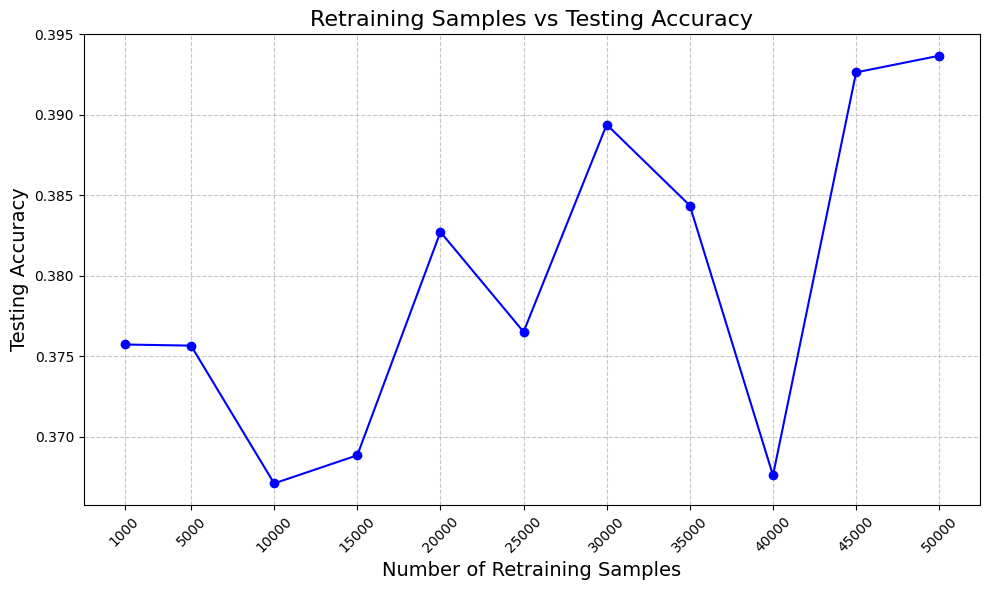

In [28]:
import matplotlib.pyplot as plt

# Extract data for plotting
retrain_samples = [res["Retraining Samples"] for res in results]
accuracies = [res["Testing Accuracy"] for res in results]

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(retrain_samples, accuracies, marker='o', linestyle='-', color='b')
plt.title("Retraining Samples vs Testing Accuracy", fontsize=16)
plt.xlabel("Number of Retraining Samples", fontsize=14)
plt.ylabel("Testing Accuracy", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(retrain_samples, rotation=45)
plt.tight_layout()
plt.show()
